In [7]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

current_dir = Path.cwd()


# 取得上一層目錄 (專案根目錄，例如 D:\NCKU\paper4)
project_root = current_dir.parent

# 把根目錄加入 Python 的搜尋路徑
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"已加入專案路徑: {project_root}")

to_delete = [m for m in sys.modules if m.startswith("src")]

for m in to_delete:
    del sys.modules[m]

print(f"已清理模組: {to_delete}")

import src.utils.data_loader as data_loader
import src.utils.helpers as helpers
import src.engine.trainer as trainer
import src.engine.evaluator as evaluator

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"] = [
    "Arial Unicode MS",
    "Microsoft JhengHei",
]  # 解決中文亂碼
plt.rcParams["axes.unicode_minus"] = False


已清理模組: ['src', 'src.utils', 'src.utils.data_loader', 'src.utils.helpers', 'src.engine', 'src.models', 'src.models.layers', 'src.models.network', 'src.utils.metrics', 'src.engine.trainer', 'src.engine.evaluator']


In [8]:
# 硬體設定
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 資料與模型參數
DATASET_PATH = Path("../dataset/USD_TWD.csv")
HORIZON = 3
LOOKBACK = 30
NUM_EPOCHS = 100
LR = 0.001
SEED = 42
TREND_CNNEXPERT_KERNELSIZE = 13
SEASONAL_CNNEXPERT_KERNELSIZE = 9
SERIESDECOMPOSITION_KERNELSIZE = 15

Using Device: cuda


In [9]:
helpers.set_seed(42)

if not DATASET_PATH.exists():
    print(f"[Error]: Dataset not found at {DATASET_PATH}")
else:
    print("[Loading Data]")
    df = pd.read_csv(DATASET_PATH)

    # 呼叫 src 裡的函式
    train_loader, val_loader, test_loader, scaler = data_loader.prepare_data(
        df, lookback=LOOKBACK, horizon=HORIZON
    )

    print(
        f"[Loading Data] Data Loaded! Train Batches: {len(train_loader)}, Test Batches: {len(test_loader)}"
    )

Seed set to: 42 (Deterministic mode ON)
[Loading Data]
[Data Split]
  Train: 4724 samples
  Val  : 678 samples
  Test : 1357 samples
[Loading Data] Data Loaded! Train Batches: 147, Test Batches: 43


In [10]:
print(f"[Training] Starting Training for {NUM_EPOCHS} epochs...")

helpers.set_seed(42)
model = trainer.train_v11(
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=DEVICE,
    horizon=HORIZON,
    num_epochs=NUM_EPOCHS,
    lr=LR,
    seq_len=LOOKBACK,
    trendCNNExpert_KernelSize=TREND_CNNEXPERT_KERNELSIZE,
    seasonalCNNExpert_KernelSize=SEASONAL_CNNEXPERT_KERNELSIZE,
    seriesDecomposition_KernelSize=SERIESDECOMPOSITION_KERNELSIZE,
    model_hyperparams={
        "use_seasonal_cnn": True,
        "use_trend_cnn": True,
    },
)

[Training] Starting Training for 100 epochs...
Seed set to: 42 (Deterministic mode ON)
Learnable Moving Average Decomposition Enabled
Trend CNN Expert Enabled
Seasonal CNN Expert Enabled

[Training] Enhanced DLinear...
Epoch   1 | LR: 0.001000 | Train: 0.4192 | Val: 0.3533 | Trend W: 0.454 | Seas W: 0.467
Epoch  10 | LR: 0.000500 | Train: 0.3392 | Val: 0.3355 | Trend W: 0.223 | Seas W: 0.283
Epoch  20 | LR: 0.000250 | Train: 0.3296 | Val: 0.3354 | Trend W: 0.209 | Seas W: 0.286
Epoch  30 | LR: 0.000063 | Train: 0.3251 | Val: 0.3364 | Trend W: 0.209 | Seas W: 0.296
[Early Stopping] No improvement for 20 epochs. Stopped at epoch 31.

[Training Completed] Loading best model (Val Loss: 0.3341)...


In [11]:
print("[Evaluation] Running Evaluation...")

res = evaluator.evaluate_model(
    model=model,
    test_loader=test_loader,
    device=DEVICE,
    horizon=HORIZON,
    scaler=scaler,
)

[Evaluation] Running Evaluation...

 FINAL MODEL EVALUATION (Horizon=1) | Ablation & Backtest
Metric               | Linear Base     | Base + CNN      | Improvement    
-----------------------------------------------------------------------------------------------
RMSE                 | 1.6638          | 1.0090          | -0.6547
R2 Score             | 0.7758          | 0.9175          | +0.1418
Avg Accuracy         | 0.5453          | 0.7133          | +0.1680
High Vol Acc         | 0.6581          | 0.8897          | +0.2316
-----------------------------------------------------------------------------------------------
 [Risk Control Strategy] (Threshold: 5.81%)
Metric                    | Buy & Hold      | Your Strategy   | Diff           
-----------------------------------------------------------------------------------------------
Sharpe Ratio              | 0.3202          | 0.7555          | +0.4353
Cumulative Return         | 9.48          % | 17.25         % | +7.77%
Max Draw

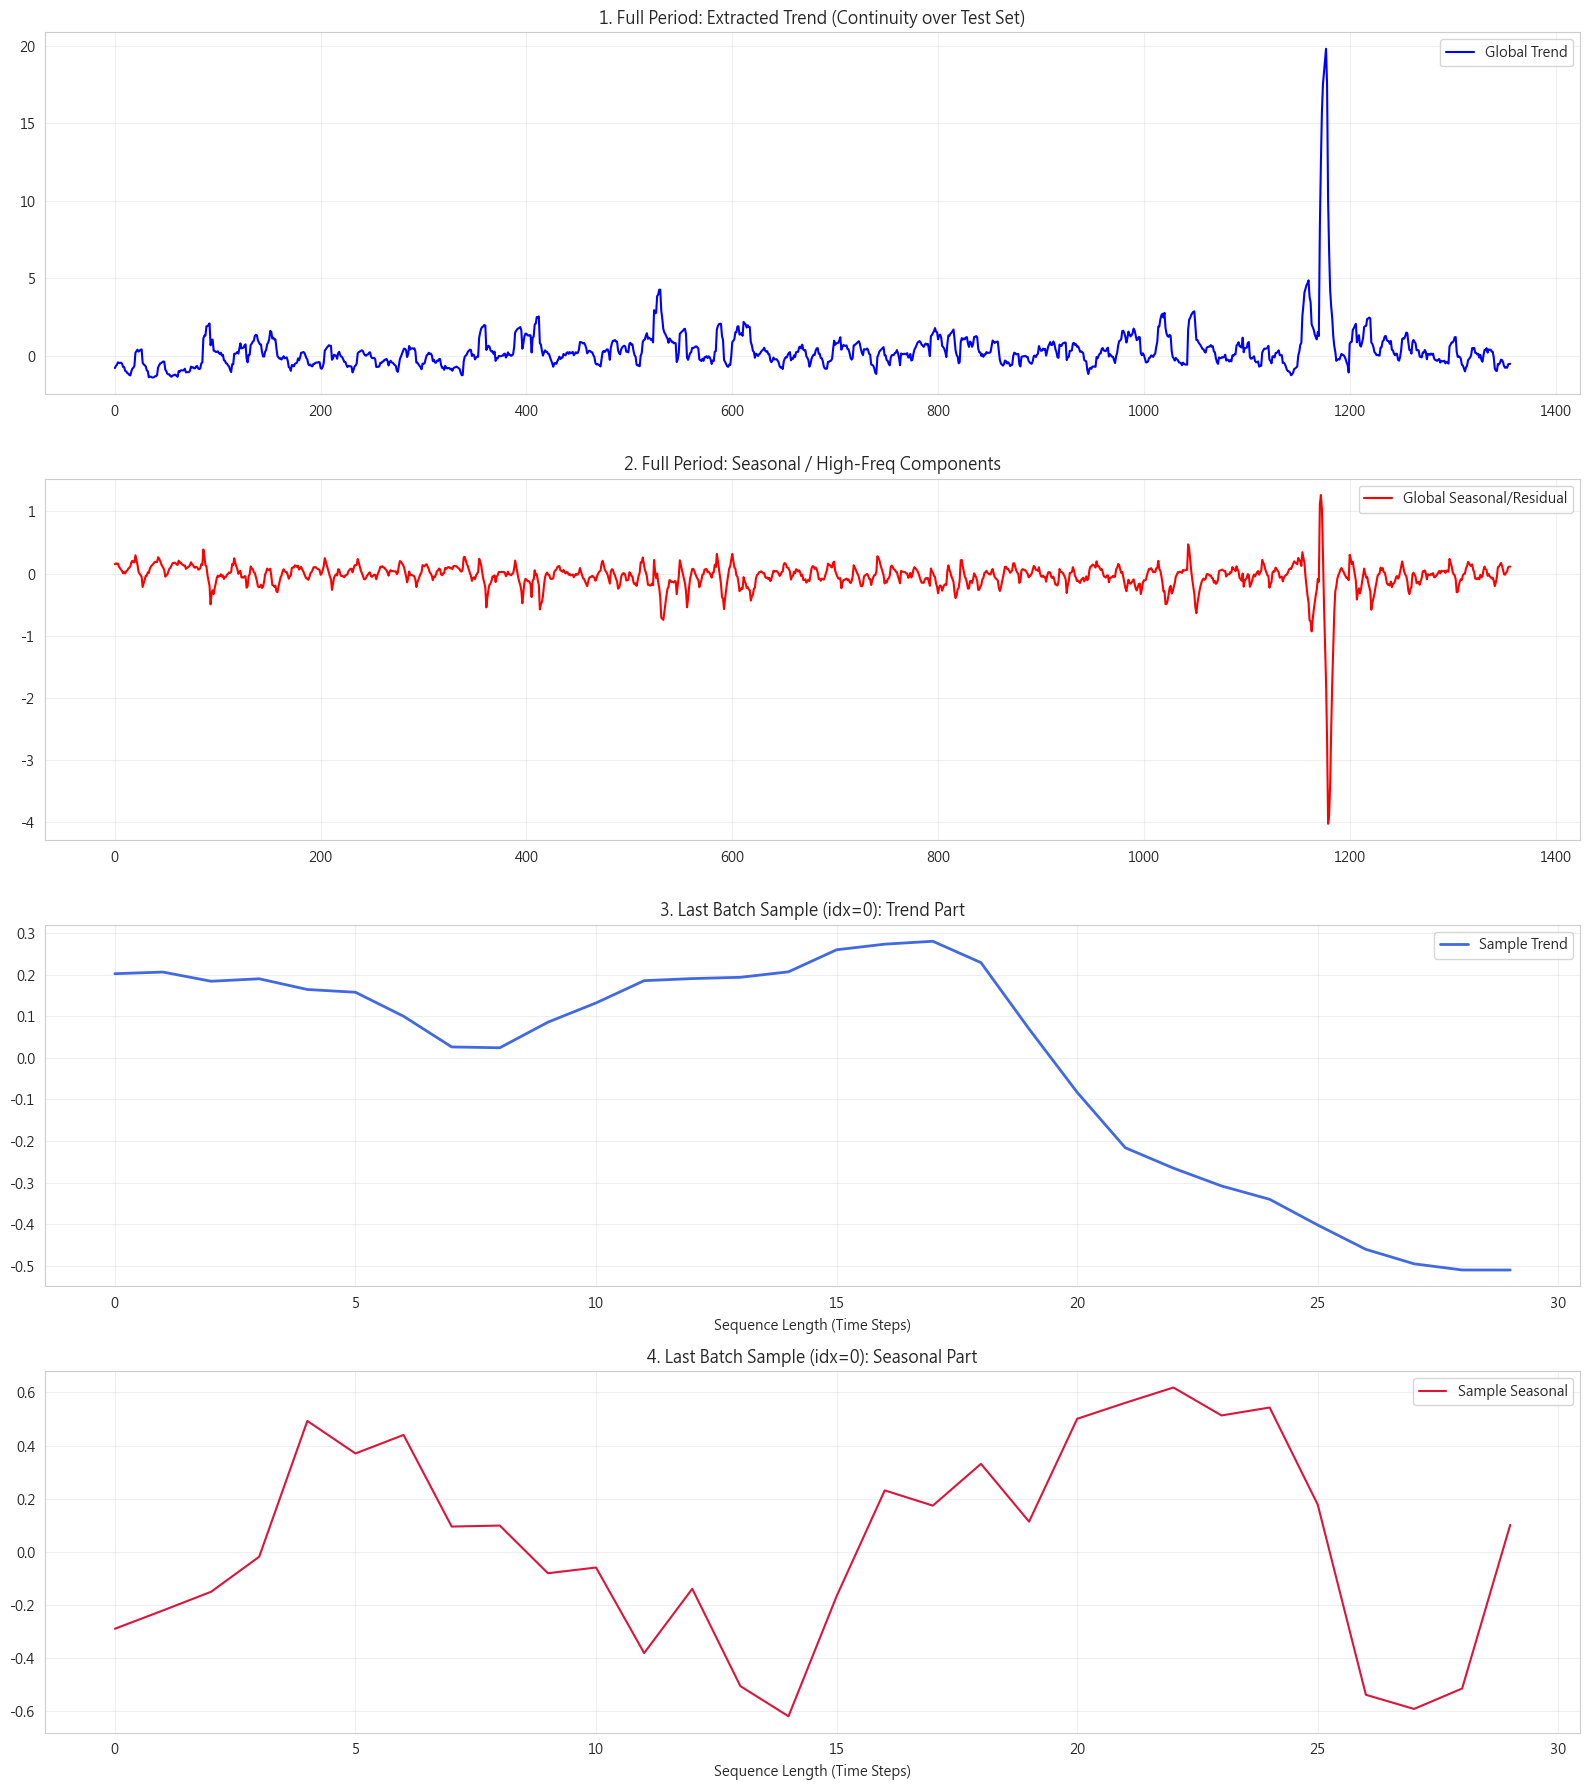

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 設定全域與樣本數據
full_trend = res["full_trend"]
full_seasonal = res["full_seasonal"]
last_batch_trend = res["plot_data"]["trend"]
last_batch_seasonal = res["plot_data"]["seasonal"]

channel = 0
sample_idx = 0

# 建立畫布：四張獨立圖表
plt.figure(figsize=(16, 18))

# --- 圖 1：全域趨勢 (Global Trend) ---
plt.subplot(4, 1, 1)
plt.plot(full_trend[:, channel], color="blue", label="Global Trend")
plt.title("1. Full Period: Extracted Trend (Continuity over Test Set)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

# --- 圖 2：全域季節性/殘差 (Global Seasonal) ---
plt.subplot(4, 1, 2)
plt.plot(full_seasonal[:, channel], color="red", label="Global Seasonal/Residual")
plt.title("2. Full Period: Seasonal / High-Freq Components")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

# --- 圖 3：最後一個 Batch 的特定樣本 Trend ---
plt.subplot(4, 1, 3)
plt.plot(
    last_batch_trend[sample_idx, :, channel],
    color="royalblue",
    linewidth=2,
    label="Sample Trend",
)
plt.title(f"3. Last Batch Sample (idx={sample_idx}): Trend Part")
plt.xlabel("Sequence Length (Time Steps)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

# --- 圖 4：最後一個 Batch 的特定樣本 Seasonal ---
plt.subplot(4, 1, 4)
plt.plot(
    last_batch_seasonal[sample_idx, :, channel],
    color="crimson",
    linewidth=1.5,
    label="Sample Seasonal",
)
plt.title(f"4. Last Batch Sample (idx={sample_idx}): Seasonal Part")
plt.xlabel("Sequence Length (Time Steps)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

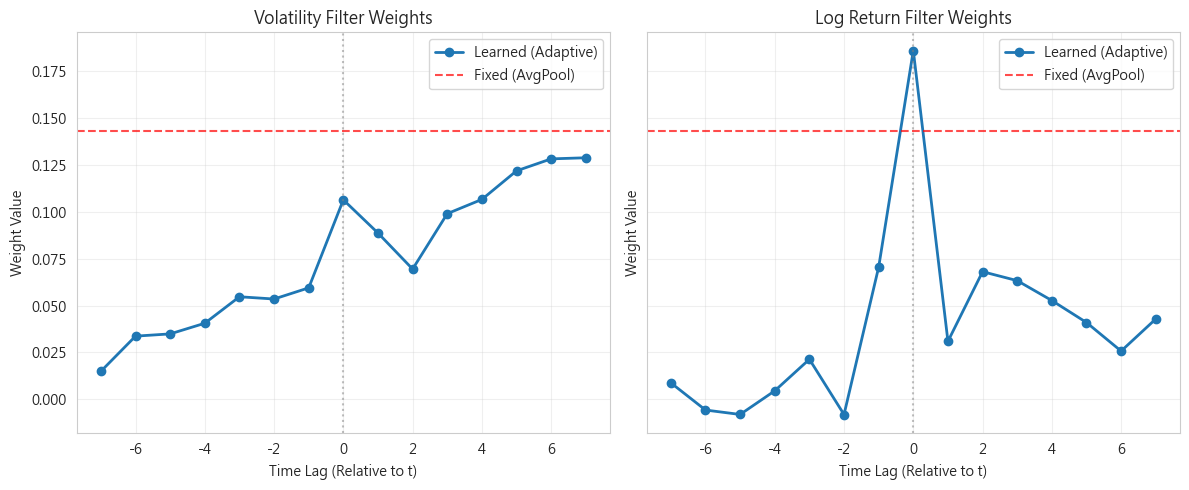

In [13]:
import matplotlib.pyplot as plt
import torch
import numpy as np


def visualize_learned_weights(model, kernel_size, feature_names=None):
    """
    繪製 Learnable Decomposition 的卷積權重

    Args:
        model: 訓練好的 EnhancedDLinear 模型
        kernel_size: 你設定的 SERIESDECOMPOSITION_KERNELSIZE (例如 11)
        feature_names: 特徵名稱列表，例如 ['Volatility', 'Log Return']
    """
    # 1. 提取權重
    # model.decomp.moving_avg.conv.weight 的形狀為 [Channels, 1, Kernel_Size]
    # 我們將其轉為 numpy array
    weights = model.decomp.moving_avg.conv.weight.data.cpu().numpy()

    num_channels = weights.shape[0]
    actual_kernel_size = weights.shape[2]

    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(num_channels)]

    # 2. 設定圖表
    fig, axes = plt.subplots(
        1, num_channels, figsize=(6 * num_channels, 5), sharey=True
    )
    if num_channels == 1:
        axes = [axes]

    # 初始的固定權重 (基準線) - 即 1/k
    fixed_weight_value = 1.0 / kernel_size

    # X 軸座標 (以中心為 0)
    # 因為是 Padding 模式，這代表相對於時間點 t 的偏移量
    x_axis = np.arange(actual_kernel_size) - (actual_kernel_size // 2)

    # 3. 繪製每個 Channel 的權重
    for i in range(num_channels):
        ax = axes[i]
        learned_w = weights[i, 0, :]

        # 畫出學習到的權重 (折線 + 點)
        ax.plot(x_axis, learned_w, marker="o", linewidth=2, label="Learned (Adaptive)")

        # 畫出初始固定權重 (虛線)
        ax.axhline(
            y=fixed_weight_value,
            color="r",
            linestyle="--",
            alpha=0.7,
            label="Fixed (AvgPool)",
        )

        # 裝飾圖表
        ax.set_title(f"{feature_names[i]} Filter Weights")
        ax.set_xlabel("Time Lag (Relative to t)")
        ax.set_ylabel("Weight Value")
        ax.grid(True, alpha=0.3)
        ax.legend()

        # 標示中心點
        ax.axvline(x=0, color="gray", linestyle=":", alpha=0.5)

    plt.tight_layout()
    plt.show()


# === 使用範例 ===
# 假設你的 Kernel Size 是 11，且有兩個特徵
visualize_learned_weights(
    model, kernel_size=7, feature_names=["Volatility", "Log Return"]
)